In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import sklearn
import impyute

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from numpy.random import seed

In [5]:
#INPUT Training DATA
data = pd.read_csv('data.csv') 
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,u,g,0.00,w,0,True,v,1.25,True,1,False,202,g,Success
1,a,58.67,u,g,4.46,q,560,True,h,3.04,True,6,False,43,g,Success
2,a,24.50,u,g,0.50,q,824,False,h,1.50,True,0,False,280,g,Success
3,b,27.83,u,g,1.54,w,3,True,v,3.75,True,5,True,100,g,Success
4,b,25.00,u,g,11.25,c,1208,True,v,2.50,True,17,False,200,g,Success


In [6]:
#INPUT Test DATA
Tdata = pd.read_csv('testdata_10.csv') 
Tdata.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,32.67,y,p,9.000,w,0,False,h,5.250,True,0,True,154,g,NaN
1,?,20.08,u,g,0.125,q,768,True,v,1.000,False,1,False,240,g,NaN
2,b,20.08,u,g,0.250,q,0,False,v,0.125,False,0,False,200,g,NaN
3,b,22.17,u,g,2.250,i,10,False,v,0.125,False,0,False,160,g,NaN
4,a,27.25,u,g,0.290,m,108,True,h,0.125,False,1,True,272,g,NaN


In [46]:
#=====================================================================================
#                           Training Data preprocessing
#=====================================================================================
data["A16"]=data["A16"].replace('Success',1,regex=True) #at A16 True=1
data["A16"]=data["A16"].replace('Failure',0,regex=True) #at A16 Flase=0

data["A8"]=data["A8"].replace(True,1,regex=True) #at A8 g=2
data["A8"]=data["A8"].replace(False,0,regex=True) #at A8 p=3

data["A11"]=data["A11"].replace(True,1,regex=True) #at A13 g=2
data["A11"]=data["A11"].replace(False,0,regex=True) #at A13 p=3

data["A13"]=data["A13"].replace(True,1,regex=True) #at A13 g=2
data["A13"]=data["A13"].replace(False,0,regex=True) #at A13 p=3

#=====================================================================================
#                               Test Data preprocessing
#=====================================================================================
Tdata["A8"]=Tdata["A8"].replace(True,1,regex=True) #at A8 g=2
Tdata["A8"]=Tdata["A8"].replace(False,0,regex=True) #at A8 p=3

Tdata["A11"]=Tdata["A11"].replace(True,1,regex=True) #at A13 g=2
Tdata["A11"]=Tdata["A11"].replace(False,0,regex=True) #at A13 p=3

Tdata["A13"]=Tdata["A13"].replace(True,1,regex=True) #at A13 g=2
Tdata["A13"]=Tdata["A13"].replace(False,0,regex=True) #at A13 p=3

#=====================================================================================
#      Extract Catagorical values and combine both datasets for ONE HOT ENCODING
#=====================================================================================

p=["A1","A3","A4","A6","A9","A15"] 
before_encode = pd.concat([data.loc[:,p]  , Tdata.loc[:,p]])
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(before_encode) #One Hot Encording 

#change of the size of the data set and names of new attributes
new_att=enc.get_feature_names(p)

In [47]:
after_encode=enc.transform(before_encode).toarray() #Transform the dataset to one hot encoding 
after_encode_df = pd.DataFrame(data=after_encode,columns=new_att) 
Miss_att=dict()
for i in p:
    if (i+"_?") in new_att:
        val_list=set(data[i].unique())
        val_list.discard("?")
        Miss_att[i]=list(val_list)
    

#=====================================================================================
#                          Disjoin Test Data and Training Data
#=====================================================================================

DJData= after_encode_df.head(len(data))
DJTest=  after_encode_df.tail(len(Tdata))

#=====================================================================================
#                 Update missing values in Test Data and Training Data
#=====================================================================================
for i in Miss_att:
    change_index=DJData[DJData[i+"_?"] == 1].index.tolist()
    for j in Miss_att[i]:
        for k in change_index:
            DJData.xs(k)[i+"_"+j] = np.nan

for i in Miss_att:
    change_index=DJTest[DJTest[i+"_?"] == 1].index.tolist()
    for j in Miss_att[i]:
        for k in change_index:
            DJTest.xs(k)[i+"_"+j] = np.nan
            
#=====================================================================================
#             join Test Data and Training Data with ciontinues variables
#=====================================================================================
p_d=["A2","A5","A7","A8","A10","A11","A12","A13","A14"]
Pre_Data = pd.concat([data.loc[:,p_d],DJData, ], axis=1, join='inner')
DJTest= pd.DataFrame(data=np.array(DJTest),columns=new_att) 
Pre_Test =  pd.concat([Tdata.loc[:,p_d],DJTest ], axis=1, join='inner')


In [51]:
#=====================================================================================
#             Fill the missing values of Test Data and Training Data 
#=====================================================================================
import numpy as np
from sklearn.impute import KNNImputer

p_f=Pre_Data.columns 
Before_filling = pd.concat([Pre_Data.loc[:,p_f]  , Pre_Test.loc[:,p_f]])
Before_filling=Before_filling.replace('?',np.NaN) #remove \t from data

subdata_in = Before_filling.loc[:,p_f]

imputer = KNNImputer(n_neighbors=400)
subData=imputer.fit_transform(subdata_in)

D=dict()
for i in range (len(p_f)):
    D[p_f[i]]=subData[:, i]
After_filling = pd.DataFrame(D)

#=====================================================================================
#             Devide to Original Test Data and Training Data 
#=====================================================================================

Test = After_filling.tail(len(Pre_Test))
Test['A2'] = Test['A2'].astype(float)
Test['A14'] = Test['A14'].astype(float)


Data = After_filling.head(len(Pre_Data))
Data = Data.assign(A16 = data["A16"]) 
Data['A2'] = Data['A2'].astype(float)
Data['A14'] = Data['A14'].astype(float)

for i in p:
    
    if i+"_?" in Data:Data=Data.drop(columns=[i+"_?"])
    if i+"_?" in Test:Test=Test.drop(columns=[i+"_?"])


C:\Users\Imesh Ekanayake\.conda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Imesh Ekanayake\.conda\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


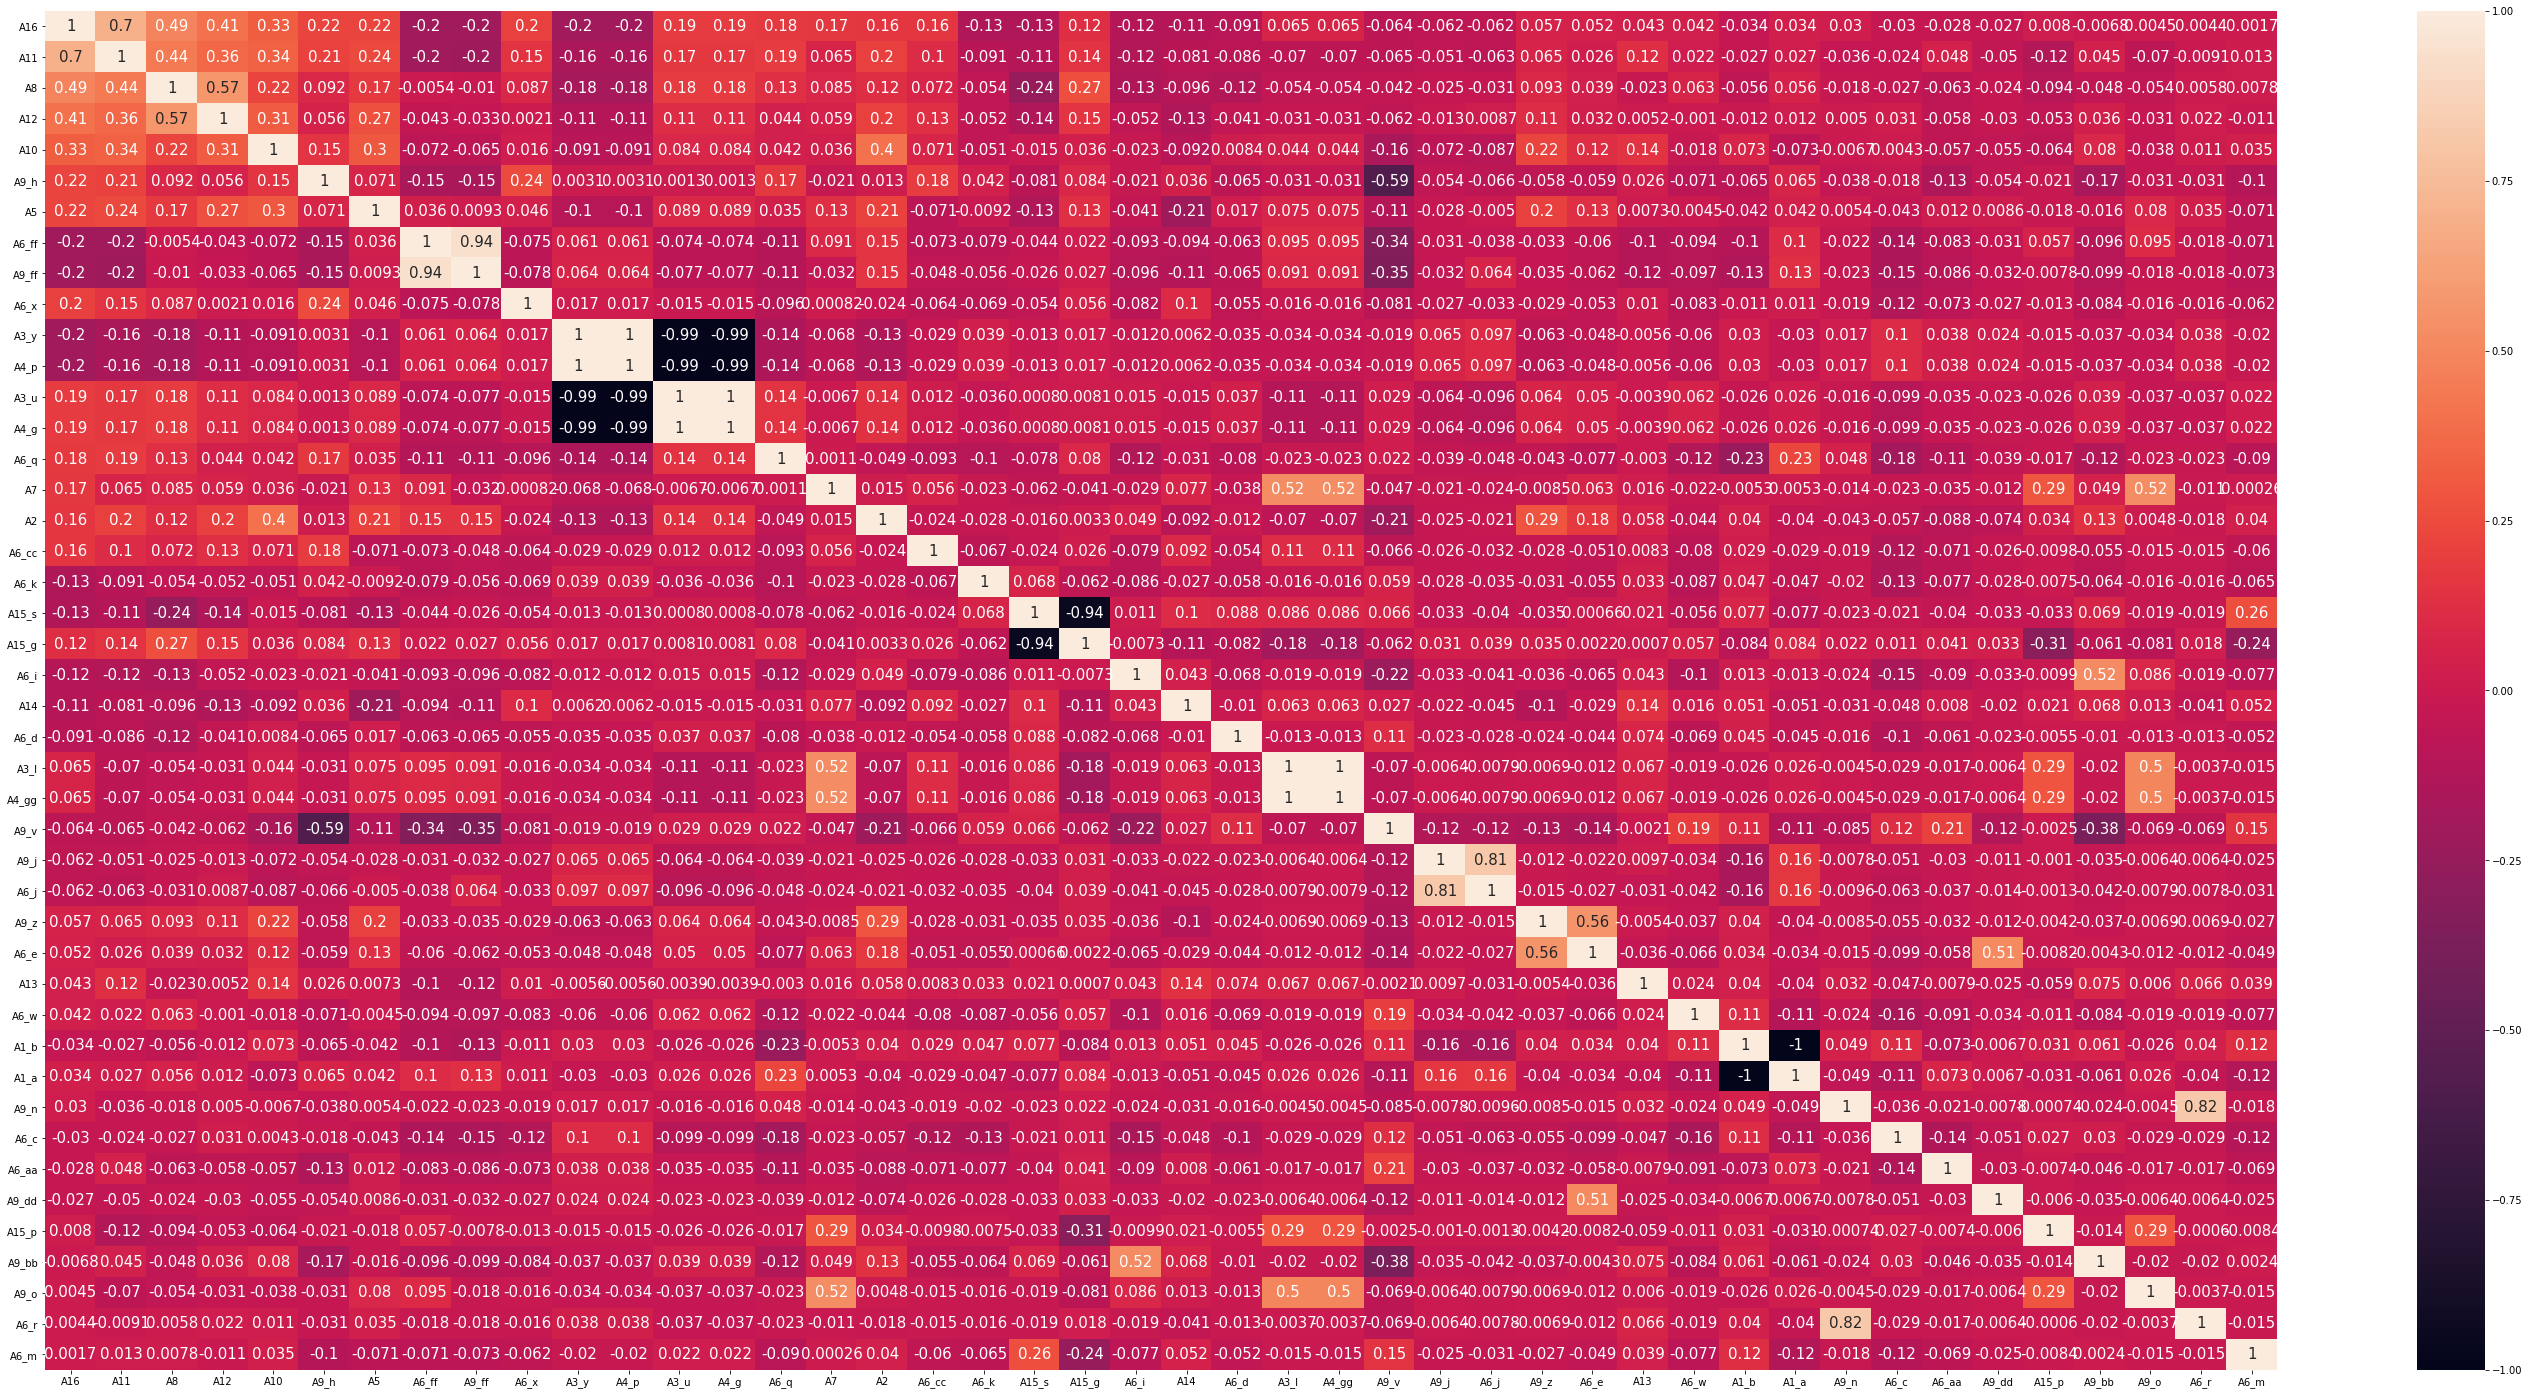

In [55]:
from pandas import DataFrame
import seaborn as sn
p_cor=abs(Data.corr()).sort_values(by=['A16']).transpose()
t_cor=p_cor.columns

t=t_cor[::-1]
df = DataFrame(Data[t],columns=t)
                        
fig, ax = plt.subplots(figsize=(50,25),sharex=True, sharey=True) 
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 15},ax=ax)

In [54]:
t_cor

Index(['A6_m', 'A6_r', 'A9_o', 'A9_bb', 'A15_p', 'A9_dd', 'A6_aa', 'A6_c',
       'A9_n', 'A1_a', 'A1_b', 'A6_w', 'A13', 'A6_e', 'A9_z', 'A6_j', 'A9_j',
       'A9_v', 'A4_gg', 'A3_l', 'A6_d', 'A14', 'A6_i', 'A15_g', 'A15_s',
       'A6_k', 'A6_cc', 'A2', 'A7', 'A6_q', 'A4_g', 'A3_u', 'A4_p', 'A3_y',
       'A6_x', 'A9_ff', 'A6_ff', 'A5', 'A9_h', 'A10', 'A12', 'A8', 'A11',
       'A16'],
      dtype='object')

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_mix = Data.loc[:,t_cor]
highCo=t_cor[:-1]
subData = df_mix.loc[:,highCo]

pca=PCA(n_components=8, copy=True, whiten=False, svd_solver='auto', tol=0.01, 
                          iterated_power='auto')

principalComponents = pca.fit_transform(subData)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2','PC3','PC4', 'PC5','PC6','PC7','PC8'])

principalDf = principalDf.join(Data["A16"])

corrMatrix = principalDf.corr()
cls=(abs(corrMatrix['A16']))
print(sum(cls))


2.361058408079702


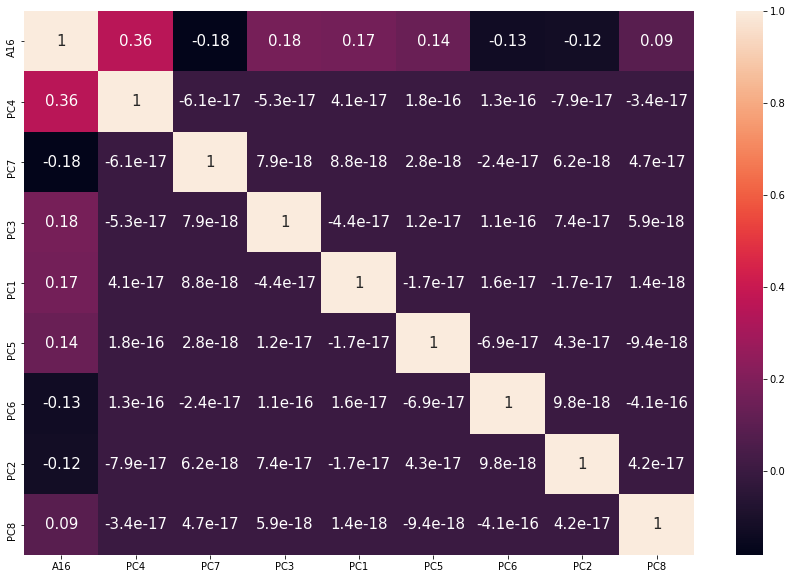

In [63]:
from pandas import DataFrame
import seaborn as sn

corrMatrix = principalDf.corr()
cls=(abs(corrMatrix['A16']))
p=cls.sort_values(ascending=False)

t=p.index

df = DataFrame(Std_Data_Train[t],columns=t)
                        
fig, ax = plt.subplots(figsize=(15,10),sharex=True, sharey=True) 
corrMatrix = df.corr()

sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 15},ax=ax)